In [159]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 1000)
pd.set_option("display.max_rows", 1000)

import warnings
warnings.filterwarnings("ignore")

In [160]:
path = "../input/pickle/"

train = pd.read_pickle(path + "train.zip")

train = train[train["item_category_big"].isin([3,4])].copy().reset_index(drop=True)

train_x = train.drop(["y"], axis=1)
train_y = train["y"]
test_x = pd.read_pickle(path + "test.zip")

test_x = test_x[test_x["item_category_big"].isin([3,4])].copy()

In [161]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65777 entries, 0 to 65776
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   year                   65777 non-null  int64  
 1   month                  65777 non-null  int64  
 2   shopID                 65777 non-null  int64  
 3   itemID                 65777 non-null  int64  
 4   item_categoryID        65777 non-null  int64  
 5   item_category_big      65777 non-null  int64  
 6   release_time           65777 non-null  float64
 7   sale_last_month        65777 non-null  float64
 8   item_price_last_month  65777 non-null  float64
 9   item_price_difference  65777 non-null  int64  
 10  item_price             65777 non-null  float64
dtypes: float64(4), int64(7)
memory usage: 5.5 MB


In [162]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 1062 to 3041
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   itemID                 180 non-null    int64  
 1   shopID                 180 non-null    int64  
 2   item_categoryID        180 non-null    int64  
 3   item_category_big      180 non-null    int64  
 4   month                  180 non-null    int64  
 5   year                   180 non-null    int64  
 6   release_time           180 non-null    int64  
 7   sale_last_month        180 non-null    float64
 8   item_price_last_month  180 non-null    float64
 9   item_price_difference  180 non-null    float64
 10  item_price             180 non-null    float64
dtypes: float64(4), int64(7)
memory usage: 16.9 KB


In [163]:
train_x.index

RangeIndex(start=0, stop=65777, step=1)

In [164]:
months 

[7, 8, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [165]:
years = [2018] * 6 + [2019] * 9
months = list(range(7, 13)) + list(range(1, 10))

In [166]:
month_list = list(range(1, 7))
year_list = [2017] + [2018]

scores = []

# custom function to run light gbm model
def run_lgb(train_X, train_y, val_X, val_y, x_test):
    params = {"objective" : "regression", 
              "metric" : "rmse", 
              "n_estimators":20000, 
              "early_stopping_rounds":200,
              "num_leaves" : 31, 
              "learning_rate" : 0.01, 
              "bagging_fraction" : 0.7,
              "bagging_seed" : 0, 
              "num_threads" : 4,
              "colsample_bytree" : 0.7,
              'max_depth': 5
             }
    
    lgtrain = lgb.Dataset(tr_x, tr_y)
    lgval = lgb.Dataset(va_x, va_y)
    model = lgb.train(params, lgtrain, 
                      valid_sets=[lgtrain, lgval], 
                      verbose_eval=1000)
    
    pred_test_y = model.predict(x_test, num_iteration=model.best_iteration)
    return pred_test_y, model

for year, month in zip(years, months):
    if year == 2019 and len(year_list) == 2:
        year_list.append(year)
    
    month_list.append(month)
    
    if month == 12:
        year += 1
        month = 1
    
    tr_x = train_x[(train_x["year"].isin(year_list))&(train_x["month"].isin(month_list))]
    va_x = train_x[(train_x["year"] == year)&(train_x["month"] == month)]
    tr_y, va_y = train_y.iloc[tr_x.index], train_y.iloc[va_x.index]
    
    # Training the model
    pred_test, model = run_lgb(tr_x, tr_y, va_x, va_y, test_x)
    
    # バリデーションデータでのスコアの確認
    va_pred = model.predict(va_x)
    score = np.sqrt(mean_squared_error(va_y, va_pred))
    
    scores.append(score)

Training until validation scores don't improve for 200 rounds
[1000]	training's rmse: 3.91057	valid_1's rmse: 3.43892
[2000]	training's rmse: 3.4536	valid_1's rmse: 2.99727
[3000]	training's rmse: 3.1451	valid_1's rmse: 2.71701
[4000]	training's rmse: 2.91294	valid_1's rmse: 2.50114
[5000]	training's rmse: 2.74675	valid_1's rmse: 2.35851
[6000]	training's rmse: 2.63983	valid_1's rmse: 2.27938
[7000]	training's rmse: 2.52925	valid_1's rmse: 2.18922
[8000]	training's rmse: 2.44362	valid_1's rmse: 2.10547
[9000]	training's rmse: 2.34284	valid_1's rmse: 2.01976
[10000]	training's rmse: 2.26096	valid_1's rmse: 1.93165
[11000]	training's rmse: 2.18812	valid_1's rmse: 1.86135
[12000]	training's rmse: 2.14547	valid_1's rmse: 1.82152
[13000]	training's rmse: 2.09102	valid_1's rmse: 1.77158
[14000]	training's rmse: 2.03965	valid_1's rmse: 1.73475
[15000]	training's rmse: 1.98715	valid_1's rmse: 1.6892
[16000]	training's rmse: 1.94116	valid_1's rmse: 1.64796
[17000]	training's rmse: 1.90579	valid

In [167]:
scores

[1.54172136185596,
 2.157777172890652,
 2.413629141928168,
 3.295677076778434,
 2.61081567129807,
 3.2456217382070944,
 1.8189553182940155,
 1.7687416628685257,
 1.911327097950768,
 1.4454130719351013,
 1.9242575808915166,
 1.9154527447915342,
 1.561312067222247,
 2.033318571102163,
 1.8966246658200967]

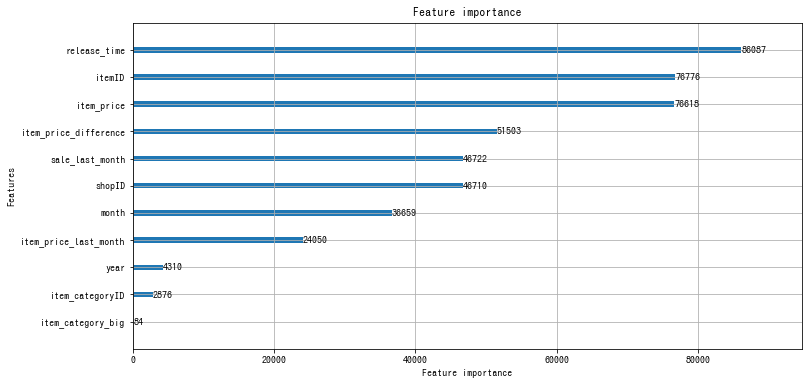

In [168]:
# 特徴量の重要度をプロットする
lgb.plot_importance(model, figsize=(12, 6))
plt.show()

In [169]:
# 予測
test_x["y"] = model.predict(test_x)

In [170]:
test_x.to_pickle('../input/pickle/test_game.zip')

In [171]:
# path = "../submission/"

# submission = pd.read_csv(path + "sample_submission.csv", header=None)

# submission.iloc[:,[1]] = pred
# submission.head()

In [172]:
# submission.to_csv(path + "submission.csv", index=False, header=None)